Epoch [1/20], Avg Loss: 190.2693 (BCE)
Epoch [2/20], Avg Loss: 167.4100 (BCE)
Epoch [3/20], Avg Loss: 163.4024 (BCE)
Epoch [4/20], Avg Loss: 161.0885 (BCE)
Epoch [5/20], Avg Loss: 159.2734 (BCE)
Epoch [6/20], Avg Loss: 157.7086 (BCE)
Epoch [7/20], Avg Loss: 156.5104 (BCE)
Epoch [8/20], Avg Loss: 155.4519 (BCE)
Epoch [9/20], Avg Loss: 154.6190 (BCE)
Epoch [10/20], Avg Loss: 153.9417 (BCE)
Epoch [11/20], Avg Loss: 153.3160 (BCE)
Epoch [12/20], Avg Loss: 152.7688 (BCE)
Epoch [13/20], Avg Loss: 152.2289 (BCE)
Epoch [14/20], Avg Loss: 151.7472 (BCE)
Epoch [15/20], Avg Loss: 151.3118 (BCE)
Epoch [16/20], Avg Loss: 150.9524 (BCE)
Epoch [17/20], Avg Loss: 150.6172 (BCE)
Epoch [18/20], Avg Loss: 150.2672 (BCE)
Epoch [19/20], Avg Loss: 149.9207 (BCE)
Epoch [20/20], Avg Loss: 149.7035 (BCE)
Epoch [1/20], Avg Loss: 49.2263 (MSE)
Epoch [2/20], Avg Loss: 42.6936 (MSE)
Epoch [3/20], Avg Loss: 41.7507 (MSE)
Epoch [4/20], Avg Loss: 41.1957 (MSE)
Epoch [5/20], Avg Loss: 40.7643 (MSE)
Epoch [6/20], Avg L

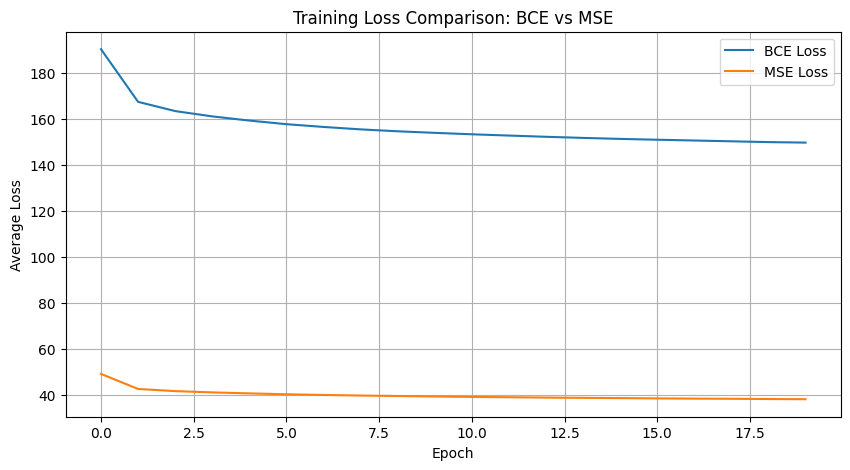

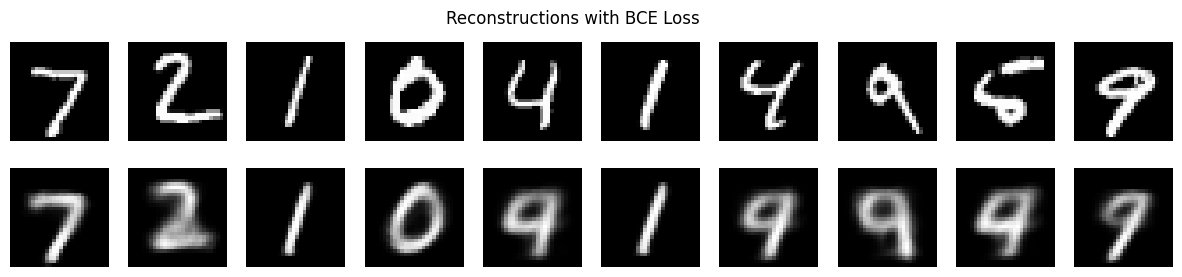

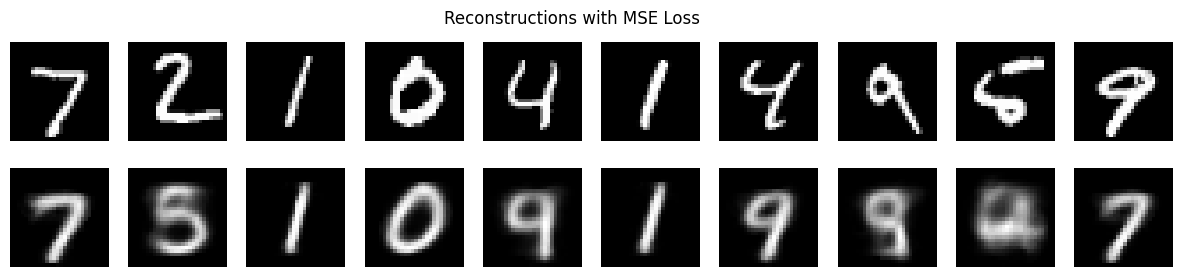

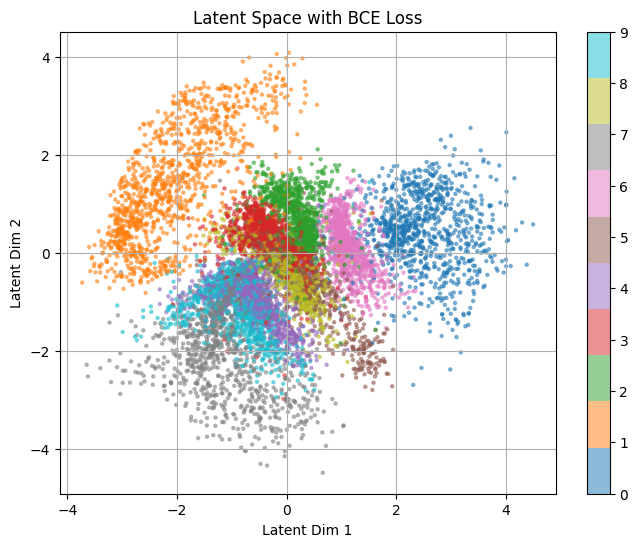

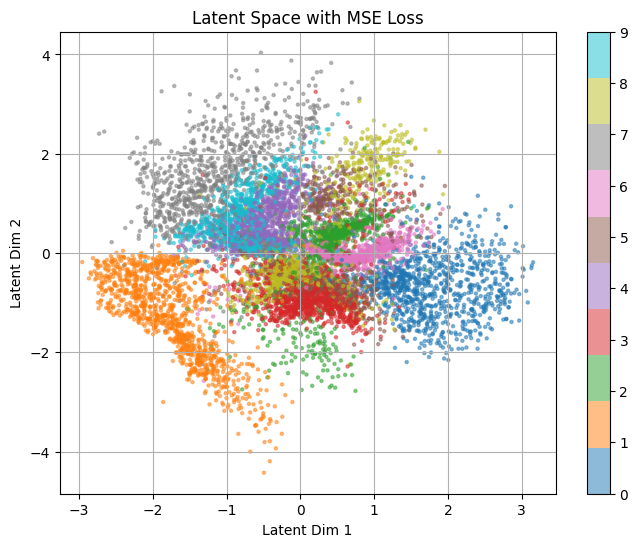

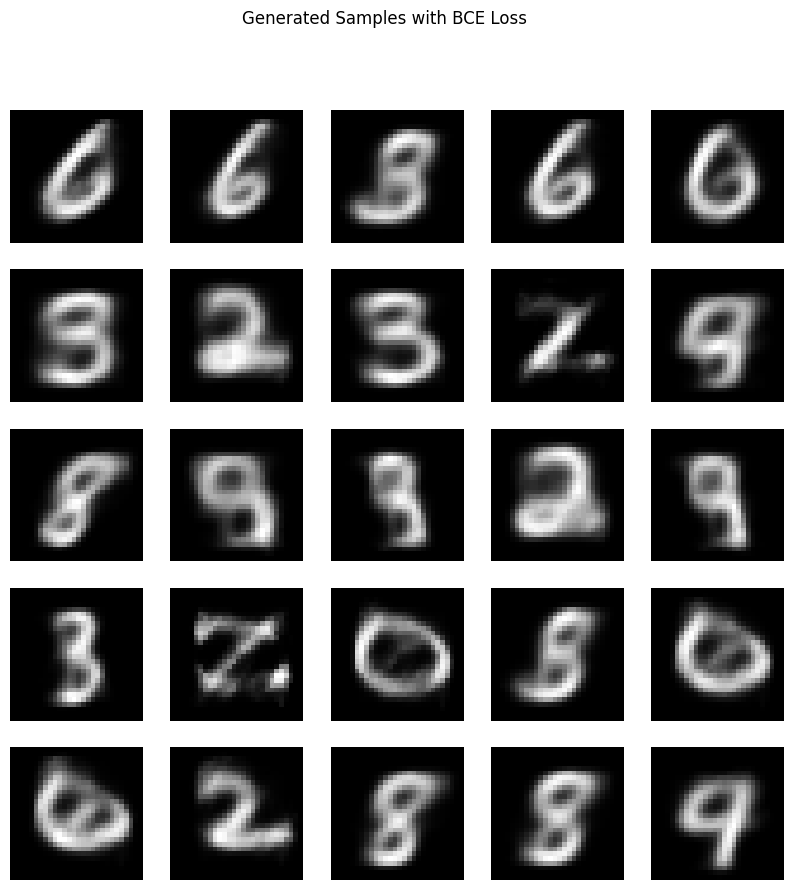

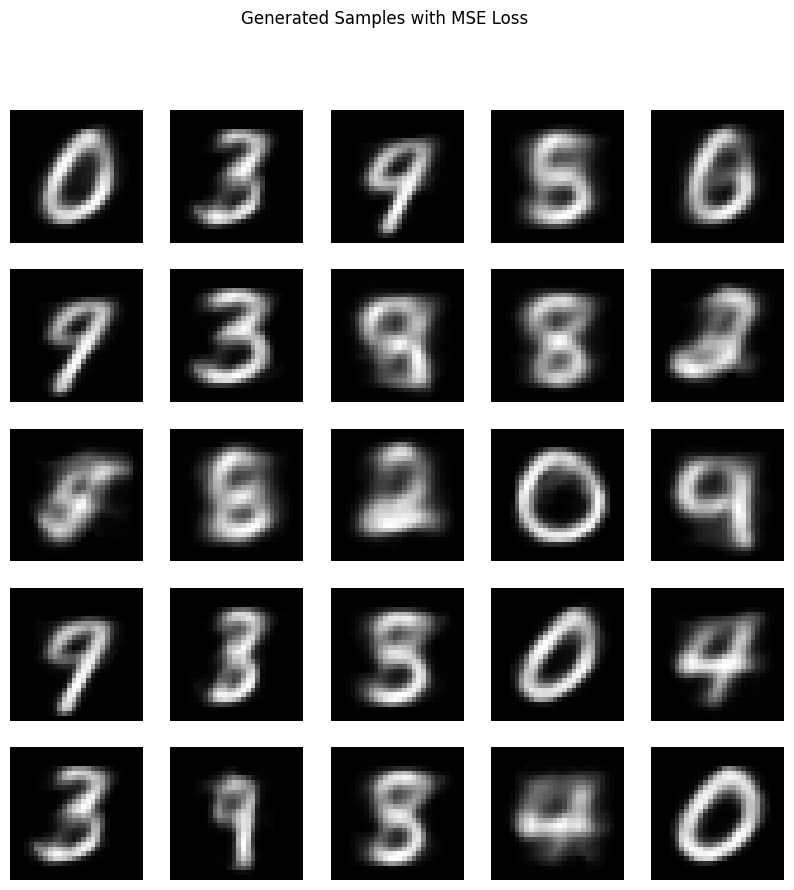

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar, loss_type):
    if loss_type == 'bce':
        recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    elif loss_type == 'mse':
        recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    else:
        raise ValueError("loss_type must be 'bce' or 'mse'")

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + KLD

# Training Function
def train(model, optimizer, data_loader, epochs, loss_type):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in data_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, loss_type)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader.dataset)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_loss:.4f} ({loss_type.upper()})')
    return loss_history

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Train VAE with BCE
model_bce = VAE().to(device)
optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
history_bce = train(model_bce, optimizer_bce, train_loader, epochs=20, loss_type='bce')

# Train VAE with MSE
model_mse = VAE().to(device)
optimizer_mse = optim.Adam(model_mse.parameters(), lr=1e-3)
history_mse = train(model_mse, optimizer_mse, train_loader, epochs=20, loss_type='mse')

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history_bce, label='BCE Loss')
plt.plot(history_mse, label='MSE Loss')
plt.title('Training Loss Comparison: BCE vs MSE')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Reconstructions
def show_reconstructions(model, test_loader, title):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)[:10]
        recon, _, _ = model(data)
        recon = recon.view(10, 1, 28, 28).cpu()
        data = data.cpu()

        fig, axs = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(10):
            axs[0, i].imshow(data[i].squeeze(), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
            axs[1, i].axis('off')
        fig.suptitle(title)
        plt.show()

show_reconstructions(model_bce, test_loader, 'Reconstructions with BCE Loss')
show_reconstructions(model_mse, test_loader, 'Reconstructions with MSE Loss')

# Plot Latent Space
def plot_latent_space(model, data_loader, title):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, lbl in data_loader:
            data = data.to(device)
            # Flatten the data before passing it to the encoder
            data = data.view(data.size(0), -1)
            mu, _ = model.encode(data)
            latents.append(mu.cpu())
            labels.append(lbl)
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.5, s=5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.grid(True)
    plt.show()

plot_latent_space(model_bce, test_loader, 'Latent Space with BCE Loss')
plot_latent_space(model_mse, test_loader, 'Latent Space with MSE Loss')

# Generate Samples
def generate_samples(model, title, n=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n*n, model.latent_dim).to(device)
        samples = model.decode(z).cpu().view(n*n, 1, 28, 28)

        fig, axs = plt.subplots(n, n, figsize=(10, 10))
        for i in range(n*n):
            axs[i//n, i%n].imshow(samples[i].squeeze(), cmap='gray')
            axs[i//n, i%n].axis('off')
        fig.suptitle(title)
        plt.show()

generate_samples(model_bce, 'Generated Samples with BCE Loss')
generate_samples(model_mse, 'Generated Samples with MSE Loss')